## Objective:

Using a simulated correlated bivariate uniform distribution (aka 'copula') and induce rank correlation on data

### Author : Nafis Sadat
#### Updated : 01/18/2017 (added better plots and a working function)

#### Load packages

In [92]:
rm(list=ls())
require(readstata13)
require(foreign)
require(ggplot2)
require(grid)
require(gridExtra)
require(reshape2)
require(dplyr)
require(VineCopula, lib.loc="/homes/sadatnfs/R/x86_64-unknown-linux-gnu-library/3.1")
require(copula, lib.loc="/homes/sadatnfs/R/x86_64-unknown-linux-gnu-library/3.1")

## Resizing notebook plot space
options(repr.plot.width=16, repr.plot.height=9)

Loading required package: grid
Loading required package: gridExtra


#### Control Structure + Bring in example dataset from /home/j/temp

In [19]:
set.seed(123)
os <- ifelse(Sys.info()["sysname"]=="Linux","/home/j/", ifelse(Sys.info()["sysname"]=="Darwin", "~/j","J:/"))
draws <- read.dta13(paste0(os,"/temp/sadatnfs/copula_exercise_GDPpc_draws_SLE.dta"))

#### Initial variable and data frame setup

In [22]:
N_draws <- 10000
offset_vars <- 4
isoiso <- "SLE"
country_sub <- subset(draws, iso3==paste0(isoiso) & year>2015)[,1:(N_draws + offset_vars)]

#### Transpose draws to long and wide by year

In [24]:
melt1 <- melt(country_sub, id.vars = c("iso3", "location_name", "total_pop", "year"))
dcast1 <- dcast(melt1, iso3 + location_name  + variable ~   year, value.var="value")

#### Create a df to record the post-copula draws, and sort 2025 apriori in order to make life easier

In [47]:
post_copula <- dcast1 
post_copula <- arrange(post_copula, `2025`)

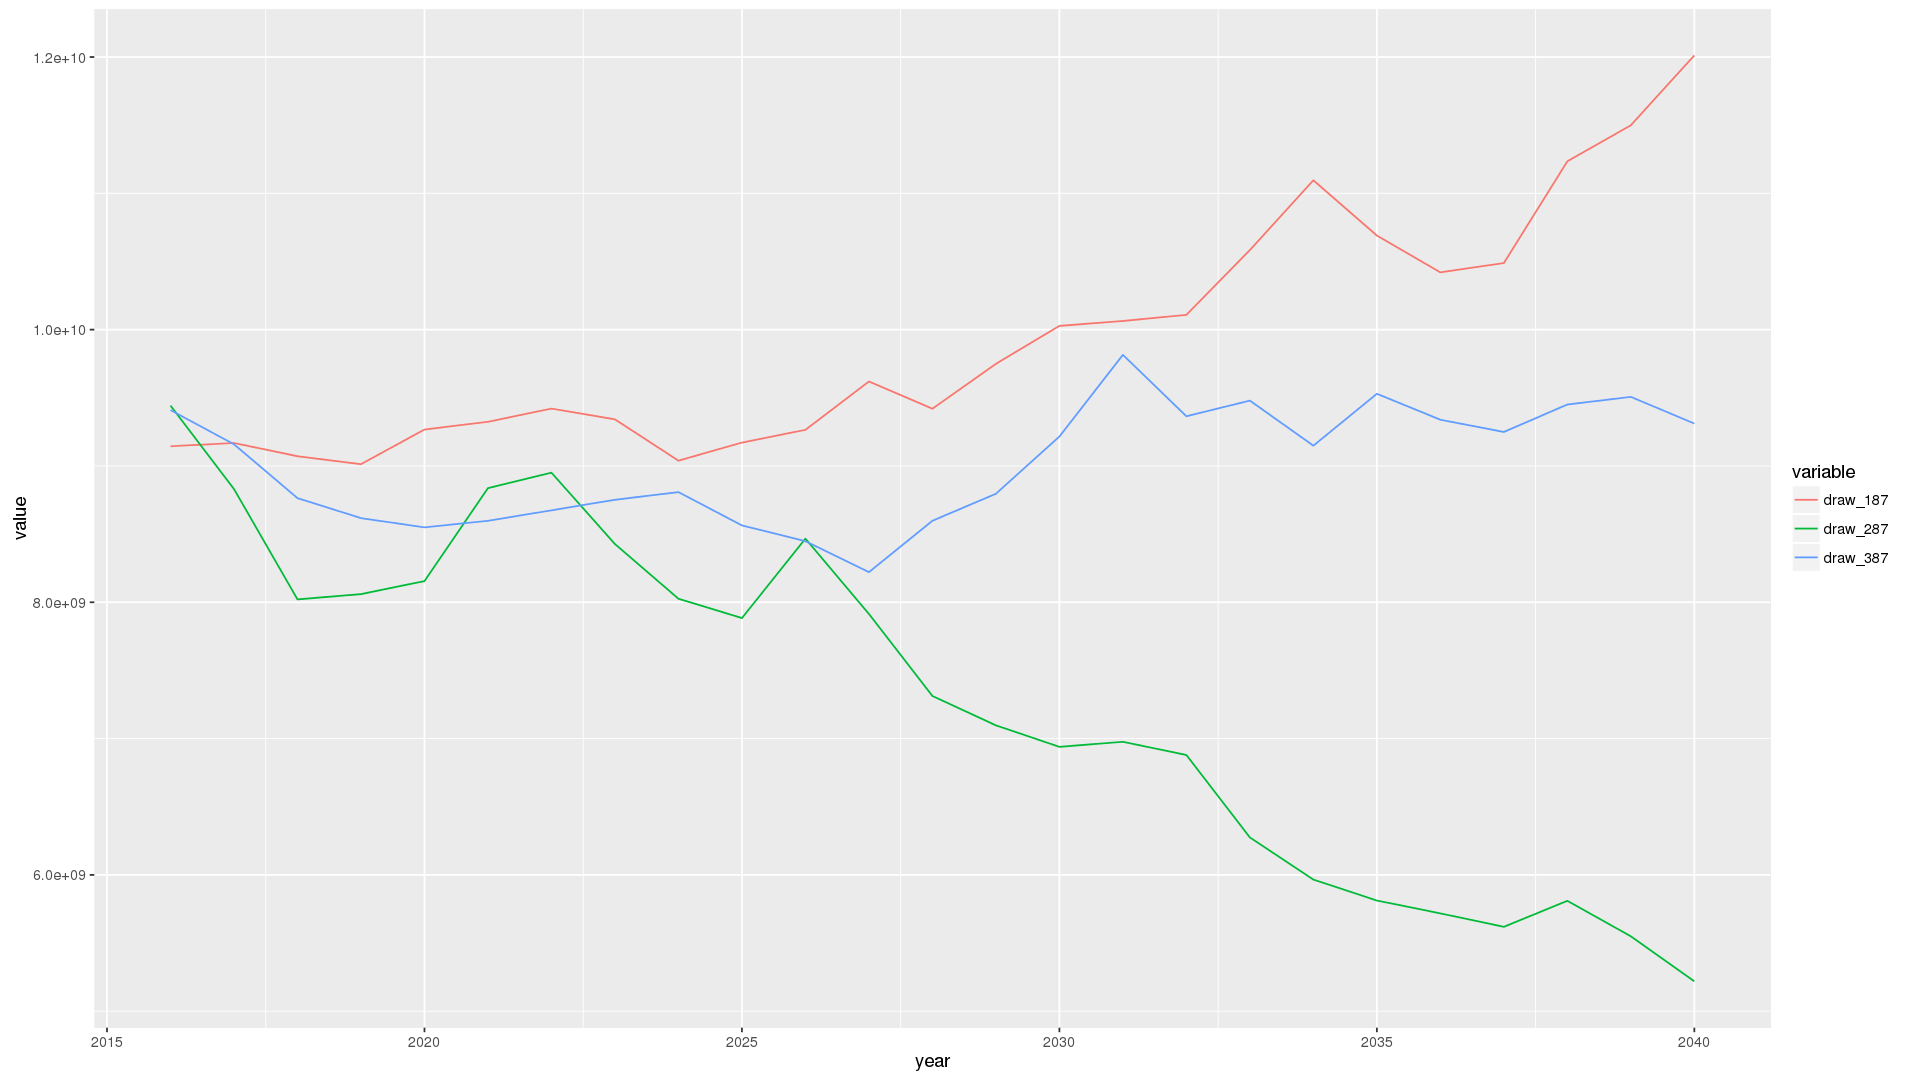

In [102]:
ggplot(subset(melt1, variable == "draw_187" | variable == "draw_287" |variable == "draw_387")) +  
geom_line(aes(x = year, y = value, group = variable, color = variable))

#### Baseline RHO: Compute correlation for each pairs of year from 2025 to 2040 (country specific)

In [50]:
rho <- vector()
j = 0
for(i in 2025:2039) {
  j = j + 1
  rho[j] = cor(x = dcast1[,paste0(i)], y = dcast1[,paste0(i+1)], method = "spearman")
}

summary(mean_rho <- mean(rho))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9871  0.9871  0.9871  0.9871  0.9871  0.9871 

#### Vector of all years

In [57]:
y1_vect <- c(2024:2016)
y2_vect <- c(2025:2017)

### The following big chunk of for loop goes through paired year, and sorts the data (inline commenting only)

In [68]:
create_sorted_data <- function(y1_vect = y1_vect,
                               
                               # Baseline casted data frame
                               cast_data = dcast1,  
                               
                               # Post Copula data frame
                               post_copula = post_copula,
                               
                               # Index of draws from cast data
                               draw_index = dcast1$variable,
                               
                               rho = 0.9, draws = N_draws) {

    ## Length of year vectors
    dims <- length(y1_vect)
    
    ## Base year vectors (year vector plus 1)
    y2_vect <- y1_vect + 1
    

    for(yr in 1:dims) {

        ## Simulate bivariate uniform distribution with a specified correlation

        # Create a normal copula object with the rho
        norm.cop <- normalCopula(rho, dim = 2, dispstr = "un")

        # Create the distribution from the copula object
        X <- rCopula(N_draws, norm.cop)


        # Convert the simulated copula to be on the support of number of draws   
        X1_sorts <- data.frame(index = ceiling(X[,1]*N_draws))
        X2_sorts <- data.frame(index = ceiling(X[,2]*N_draws))


        # Bounding if any value is above the highest number of draws 
        X1_sorts[,1] <- ifelse(X1_sorts[,1]>N_draws, N_draws, X1_sorts[,1])
        X2_sorts[,1] <- ifelse(X2_sorts[,1]>N_draws, N_draws, X2_sorts[,1])


        # Check Spearman value
        cor(X1_sorts,X2_sorts, method="spearman")

        ## Create joint ranks
        joint <- cbind.data.frame(X1_sorts, X2_sorts)
        colnames(joint) <- c("ind1", "ind2")
        joint <- arrange(joint, ind2)


        y1 = as.character(y1_vect[yr])
        y2 = as.character(y2_vect[yr])

        print(paste0("Step: ", yr))
        
        print(paste0("Year set as base: " ,y2))
        print(paste0("Year to be sorted: " ,y1))



        ## Take the two years, and take them out as vectors    
        unsorted_draws_TOSORT <- data.frame( tosort =   cast_data[, paste0(y1)] , index = draw_index)

        if (yr == 1) {
          unsorted_draws_BASE <- data.frame(  base = cast_data[, paste0(y2)] , index = draw_index) 
        }
        if (yr > 1) {
          unsorted_draws_BASE <- data.frame(  base = post_copula[, paste0("t",y2)] , index = draw_index) 

        }


        zero_X1 <- matrix(rep(0, dim(joint)[1]))
        zero_X2 <- matrix(rep(0, dim(joint)[1]))


        # Pre correlation value
        cor(unsorted_draws_TOSORT$tosort, unsorted_draws_BASE$base, method="spearman")

        # Sort our draws
        ordered_draws_tosort <- arrange(unsorted_draws_TOSORT, tosort )
        ordered_draws_base <- arrange(unsorted_draws_BASE, base )




    ## Reference year data
        ## Take these ordered draws, create a new vector, and use indices of X1_sorts to reshuffle the data:      
          coptd_base <- vector()

          j = 0

          for(i in joint[,2]) {
            j = j + 1
            coptd_base[j] = ordered_draws_base[i,1]
          }


          coptd_base <- data.frame(coptd_base)
          colnames(coptd_base)[1] <- paste0("t",y2)



          colnames(unsorted_draws_BASE)[1] <- paste0("t",y2)


    ## To-be-sorted year data    
        ## Now, we have to merge back the draw indices         
          coptd_tosort <- vector()

          j = 0
          for(i in joint[,1]) {
            j = j + 1
            # print(paste0("Row ",j ," with row ", i))

            coptd_tosort[j] = ordered_draws_tosort[i,1]
          }



        coptd_tosort <- data.frame(coptd_tosort)
        colnames(coptd_tosort)[1] <- paste0("t",y1)


        colnames(unsorted_draws_TOSORT)[1] <- paste0("t",y1)


       ## Do some intermediate graphing to check status 
        # par(mfrow=c(1,2),oma = c(0, 0, 2, 0))
        # plot(unsorted_draws_TOSORT[,1], unsorted_draws_BASE[,1], main = "before sorting")
        # plot(coptd_tosort[,1] , coptd_base[,1] , main = "After sorting using Gaussian copula")
        # mtext("Target rho from 2025-2040 ", outer = TRUE, cex = 1.5)



        ## Column bind the newly mapped draws
        copt_bind <- cbind.data.frame(coptd_base, coptd_tosort)
        post_copula <- cbind.data.frame(post_copula, copt_bind[,2])


        # post_copula <- cbind.data.frame(post_copula,  to_sub[,2])
        colnames(post_copula)[dim(post_copula)[2]] <- paste0("t",y1)


        # What's our new rho?
        print(paste0("New Rho: ", cor(coptd_tosort[,1], coptd_base[,1], method="spearman")))



      }

    return(post_copula)
    
    }

### Run the function to sort the data with the induced correlation

In [70]:
post_2 <- create_sorted_data(y1_vect = y1_vect, 
                             cast_data = dcast1,  
                             post_copula = post_copula, 
                             draw_index = dcast1$variable,
                             rho = mean_rho, 
                             draws = N_draws)

[1] "Step: 1"
[1] "Year set as base: 2025"
[1] "Year to be sorted: 2024"
[1] "New Rho: 0.985993350181094"
[1] "Step: 2"
[1] "Year set as base: 2024"
[1] "Year to be sorted: 2023"
[1] "New Rho: 0.985363287940839"
[1] "Step: 3"
[1] "Year set as base: 2023"
[1] "Year to be sorted: 2022"
[1] "New Rho: 0.985172183541805"
[1] "Step: 4"
[1] "Year set as base: 2022"
[1] "Year to be sorted: 2021"
[1] "New Rho: 0.985666122165669"
[1] "Step: 5"
[1] "Year set as base: 2021"
[1] "Year to be sorted: 2020"
[1] "New Rho: 0.986034736638926"
[1] "Step: 6"
[1] "Year set as base: 2020"
[1] "Year to be sorted: 2019"
[1] "New Rho: 0.985815766276447"
[1] "Step: 7"
[1] "Year set as base: 2019"
[1] "Year to be sorted: 2018"
[1] "New Rho: 0.985893676617961"
[1] "Step: 8"
[1] "Year set as base: 2018"
[1] "Year to be sorted: 2017"
[1] "New Rho: 0.985167765949254"
[1] "Step: 9"
[1] "Year set as base: 2017"
[1] "Year to be sorted: 2016"
[1] "New Rho: 0.986579124728828"


#### Saving out the output and bind with baseline data

In [88]:
new_cast_col <- c(paste0("t",c(2016:2024)), paste0(c(2025:2040)))
new_cast_colNames <- c("iso3", "location_name", "variable", c(2016:2040))

dcast_copula <- post_2[,c("iso3", "location_name", "variable", new_cast_col)]
colnames(dcast_copula) <- new_cast_colNames
dcast2_copula <- cbind(dcast_copula[, c("iso3", "location_name")], dcast_copula[,paste0(c(2016:2040))])

#### Create a fake placeholder draw variable

In [89]:
dcast2_copula$variable <- paste0("draw_", c(1:N_draws))

melt2 <- melt(dcast2_copula, id.vars=c("iso3", "location_name", "variable"))
colnames(melt2) <- c("iso3", "location_name", "variable", "year", "gdp")

dcast2 <- dcast(melt2, value.var = "gdp", iso3 + location_name + year ~ variable)
dcast2$year <- as.numeric(dcast2$year) + 2015
dcast2 <- dcast2[ ,c("iso3", "location_name", "year", paste0("draw_", c(1:10000)))]

### Testing out plots (15 random draws)

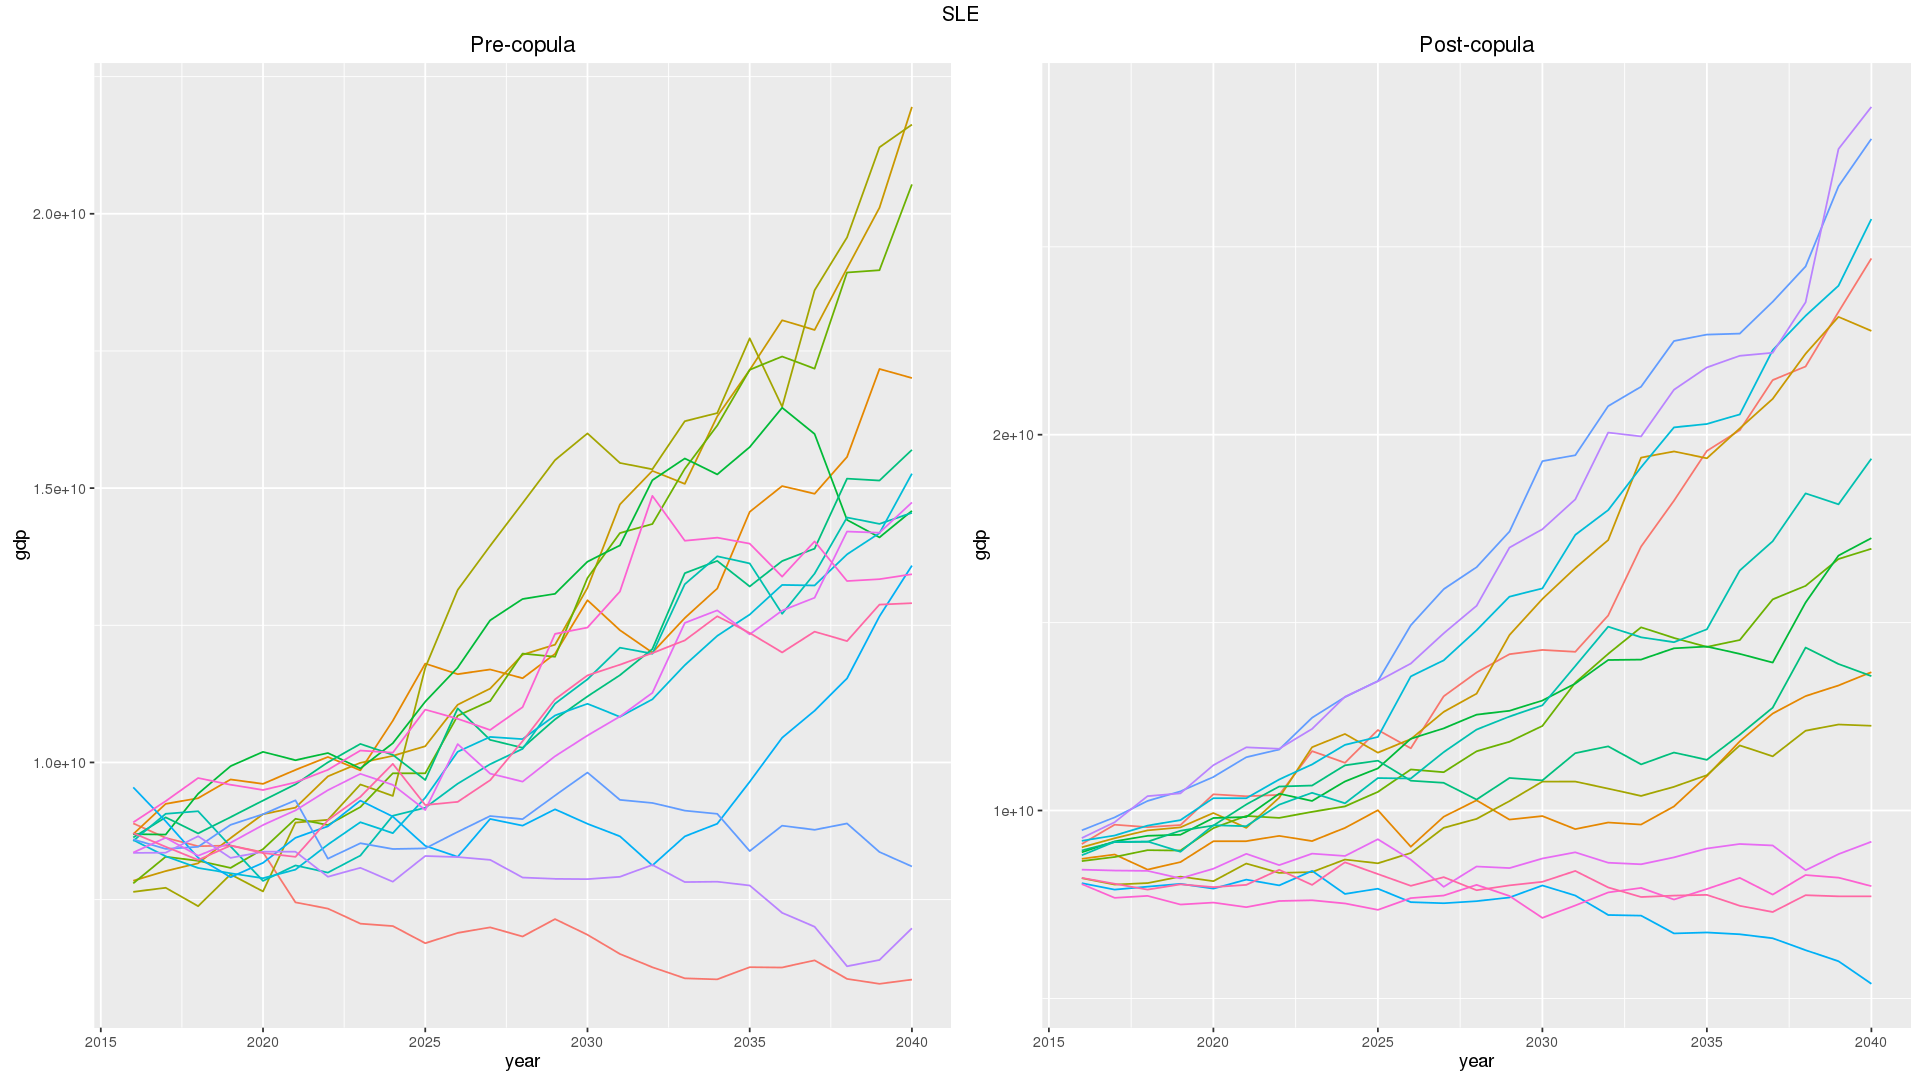

In [100]:
## Pre copula data
melt_pre <- melt(dcast1, id.vars=c("iso3", "location_name", "variable"), value.name = "gdp")
colnames(melt_pre)[4] <- "year"
melt_pre <- dcast(melt_pre, value.var = "gdp", iso3 + location_name + year ~ variable)

## Vector of random draws
samp_colnames <- c("iso3", "year", paste0("draw_",sample(N_draws, size = 15)))

## Subset out each of the 
melt_pre <- melt_pre[,samp_colnames]

## Post copula data
melt_post <- dcast2[,samp_colnames]

## Melt the data post-sampling
melt_pre <- melt(melt_pre, id.vars = c("iso3", "year"), value.name = "gdp")
melt_pre$year <- as.numeric(melt_pre$year) + 2015
melt_post <- melt(melt_post, id.vars = c("iso3", "year"), value.name = "gdp")

## Plot objects
pre_copula<-ggplot() +
  geom_line(data = melt_pre, aes(x= year, y = gdp, group= variable,color = variable)) + 
theme(legend.position = "none") + ggtitle("Pre-copula")

post_copula<-ggplot() +
  geom_line(data = melt_post, aes(x= year, y = gdp, group= variable,color = variable)) + 
theme(legend.position = "none") + ggtitle("Post-copula")

grid.arrange(pre_copula, post_copula, ncol=2, top = paste0(isoiso))

#### Save out

In [101]:
# write.dta(dcast2, paste0(os,"/temp/sadatnfs/", isoiso,".dta"))